**Introduction**
Housing prices are based on a variety of factors, and fluctuate with the health of the economy. However, there should always be things about a home that intrinsically make it higher value than others. Removing economic fluctuations, what makes a house worth more than another, and how can we predict the value of a house? 

<ins>Goal:</ins> Predict housing prices based on a combination of attributes.

To address this question, we will be using a comprehensive dataset that includes various attributes of residential properties. The dataset will include information on property size, architectural features, the presence of amenities (such as parking or whether the house is near the mainroad), and infrastructures within the house. By analyzing these variables and comparing the non-economic factors, we aim to identify what variables have the greatest influence on price prediction, that can be used to predict house prices.

**Methods**
Our base model will be a multivariate regression with our quantitative variables that are known to increase house value (area, bedrooms, bathroom, stories). It will involve a mixture of different types of plots, correlation analysis and regression model. We will be comparing the effect of other categorical variables (whether or not the house has a basement, heating, air conditioning, etc.) to identify the most relevant predictor variables that significantly affect housing prices. Then, we will use 1 to 2 categorical variables that best increase the accuracy of the model from the last step to predict the house prices. Once the model is complete, we will visualize the results with a scatterplot.

**Preliminary Exploratory Data Analysis**

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

In [17]:
url <- "https://raw.githubusercontent.com/chwu01/DSCI-Group-Project/main/data/Housing.csv?token=GHSAT0AAAAAACJLPUGVZAVJVT4ABCKVY53KZJ4B4RQ"
housing <- read_csv(url)

housing <- housing |>
    mutate(furnishingstatus = as_factor(furnishingstatus),
          mainroad = as_factor(mainroad),
          guestroom = as_factor(guestroom),
          basement = as_factor(basement),
          hotwaterheating = as_factor(hotwaterheating),
          airconditioning = as_factor(airconditioning),
          prefarea = as_factor(prefarea))

housing

Rows: 545 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): mainroad, guestroom, basement, hotwaterheating, airconditioning, pr...
dbl (6): price, area, bedrooms, bathrooms, stories, parking

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>
13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished
1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished


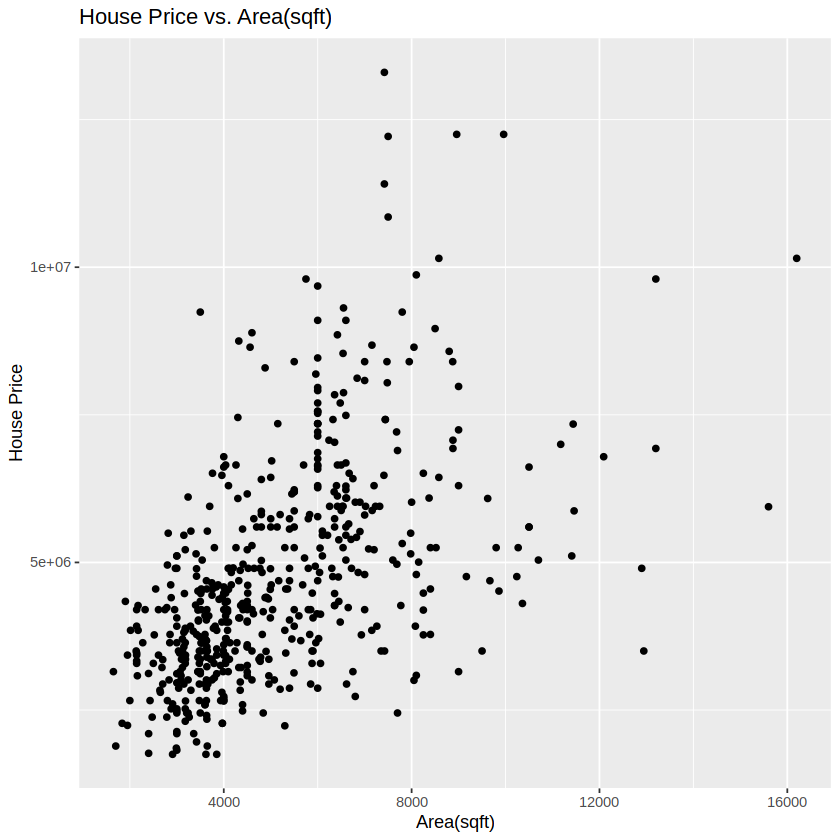

In [18]:
#Scatterplot for price vs. area
housing_plot <- housing|>
    ggplot(aes(x = area, y = price))+
    geom_point()+
    labs(x = "Area(sqft)", y = "House Price")+
    ggtitle("House Price vs. Area(sqft)")
housing_plot

In [5]:
# Checking for NA values

housing_check_na <- housing |>
    summarize(check_for_na = sum(is.na(housing)))

housing_check_na

check_for_na
<int>
0


In [25]:
# Checking the spread of number of bedrooms in the dataset after splitting data
set.seed(9999)

housing_split <- initial_split(housing, prop = 0.75, strata = bedrooms)
housing_train <- training(housing_split)
housing_test <- testing(housing_split) 

housing_bedroom_count <- housing_train |>
    group_by(bedrooms) |>
    summarize(observations = n())

housing_bedroom_count

bedrooms,observations
<dbl>,<int>
1,2
2,101
3,225
4,72
5,6
6,2


In [28]:
# Dividing area into bins to examine the distribution of house square footage

housing_area_bins <- housing_train |>
    select(price, area, bedrooms)

breaks <- c(0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000)
tags <- c("0-1000", "1000-2000", "2000-3000", "3000-4000", "4000-5000", "5000-6000", "6000-7000", "7000-8000", "8000-9000", "9000-10000",
          "10000-11000", "11000-12000", "12000-13000", "13000-14000", "14000-15000", "15000-16000", "16000-17000")

group_tags <- cut(housing_area_bins$area, breaks = breaks, include.lowest = TRUE, right = FALSE, labels = tags)

# group_tags

housing_area_buckets <- housing_train |>
    select(price, area) |>
    mutate(area_bucket = group_tags) |>
    group_by(area_bucket) |>
    summarize(number_of_houses = n())

housing_area_buckets

area_bucket,number_of_houses
<fct>,<int>
1000-2000,3
2000-3000,35
3000-4000,108
⋮,⋮
13000-14000,1
15000-16000,1
16000-17000,1


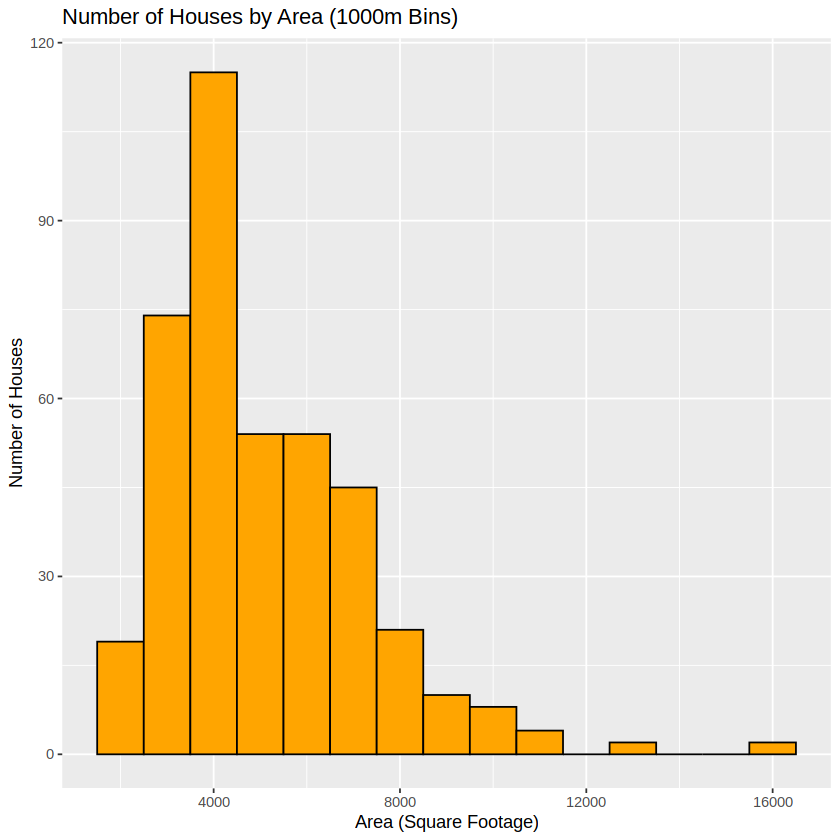

In [30]:
# Visualizing above in a histogram (using training data only)

number_of_houses_by_area <- housing_train |>
    ggplot(aes(x = area)) +
    geom_histogram(binwidth = 1000, colour = "black", fill = "orange") +
    ggtitle("Number of Houses by Area (1000m Bins)") +
    labs(x = "Area (Square Footage)", y = "Number of Houses")

number_of_houses_by_area

**Initial Observations:** There are significantly more observations of houses less than 8000 square feet. It's likely that our predictive model will be much more accurate within that range. Going beyond 8000 square feet will likely decrease the accuracy because there is so little data to train with.

**Expected outcomes**
We anticipate that our analysis will confirm that certain quantitative variables, such as property size and number of bedrooms, will have a positive relationship with the value of the house.  Additionally, we expect that the presence of certain categorical values such as parking and accessibility to mainroad will generally lead to an increase in the housing price. However, subjective factors like the buyer's perception of the value of these amenities could affect how much of an increase there is. These findings are significant because they offer future house owners a more precise understanding of the basic factors influencing house prices.


**Future questions**
- Is it cheaper to buy a house with amenities included or buy one without and install yourself?
- What other variables can impact a house(e.g. age of the house, color)?
